In [1]:
from __future__ import division
from __future__ import with_statement
from __future__ import print_function

%load_ext autoreload
%autoreload 2

import numpy as np
import deepmodels
import json
import time
import argparse
import os.path
import subprocess
import imageutils
import utils
import deepmodels_torch
import deepmodels_torch_facenet
from facenet_pytorch import InceptionResnetV1
import torch
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_path = '/home/vk352/FaceDetection/datasets/vgg_face2/train_aligned/'

id_set = set([f for f in os.listdir(data_path) if not f.endswith("txt")])
id_list = list(id_set)
print(len(id_list))

8631


In [3]:
print('n005706' in id_list)

False


In [4]:
model = InceptionResnetV1(pretrained='casia-webface').eval().to("cuda")
model.classify = False

In [5]:
K = 100
image_dims = (200, 200)

In [6]:
features = []
for i, person_id in enumerate(id_list):
    if i % 50 == 0:
        print("iter: {} / {}".format(i, len(id_list)))
        torch.save({"features": features}, "/home/vk352/FaceDetection/datasets/vgg_face2/train_facenet_webface_pretrained_features.pth")
    images = ["{}/{}/".format(data_path, person_id)+f for f in os.listdir("{}/{}/".format(data_path, person_id)) if os.path.isfile(os.path.join("{}/{}/".format(data_path, person_id), f))]
    #print(images)
    data = torch.from_numpy(np.array(list(utils.image_feed(images[:K],image_dims)))).permute(0, 3, 1, 2).to("cuda").float()
    feature = model(data)
    features.append(feature.data.cpu())
    del data, feature
torch.save({"features": features}, "/home/vk352/FaceDetection/datasets/vgg_face2/train_facenet_webface_pretrained_features.pth")

iter: 0 / 8631


RuntimeError: CUDA out of memory. Tried to allocate 36.00 MiB (GPU 0; 10.92 GiB total capacity; 4.26 GiB already allocated; 10.44 MiB free; 4.34 GiB reserved in total by PyTorch)

In [53]:
checkpoint = torch.load("/home/vk352/FaceDetection/datasets/vgg_face2/train_facenet_pretrained_features.pth")
checkpoint["id_list"] = id_list
torch.save(checkpoint, "/home/vk352/FaceDetection/datasets/vgg_face2/train_facenet_pretrained_features.pth")


In [37]:
feature_mean = [feature.mean(0) for feature in features]
print(len(feature_mean))


8631


In [38]:
feature_mean_numpy = torch.stack(feature_mean, dim=0).cpu().numpy()
print(feature_mean_numpy.shape)

(8631, 512)


In [55]:
def dist(feat, dist_type="l2"):
    if dist_type == "l2":
        return euclidean_distances(feat)
    elif dist_type == "cos":
        return cosine_distances(feat)
    
def get_image(person_id):
    images = ["{}/{}/".format(data_path, person_id)+f for f in os.listdir("{}/{}/".format(data_path, person_id)) if os.path.isfile(os.path.join("{}/{}/".format(data_path, person_id), f))]
    return mpimg.imread(images[1])

def get_closed_image(person_id_1, person_id_2, dist_type="l2"):
    if dist_type == "l2":
        dist = euclidean_distances(features[person_id_1], features[person_id_2])
    elif dist_type == "cos":
        dist = cosine_distances(features[person_id_1], features[person_id_2])
    

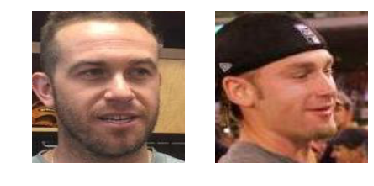

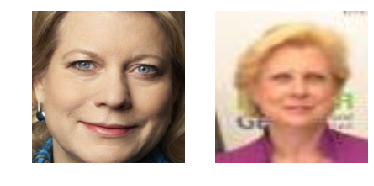

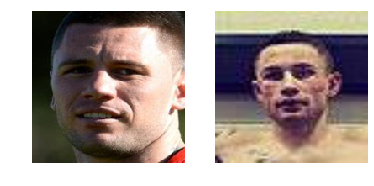

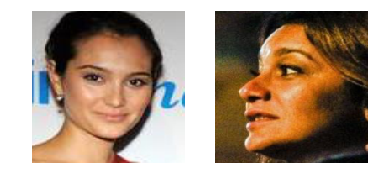

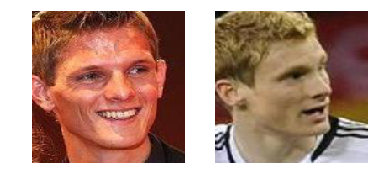

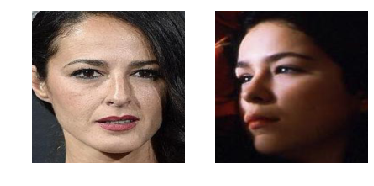

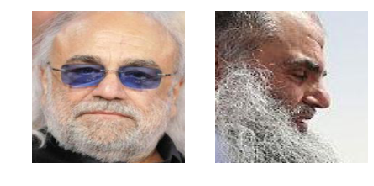

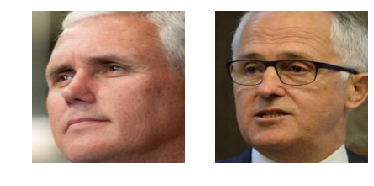

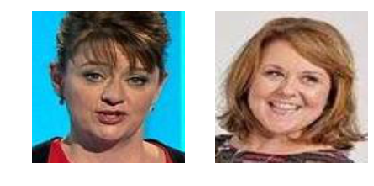

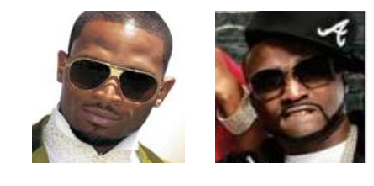

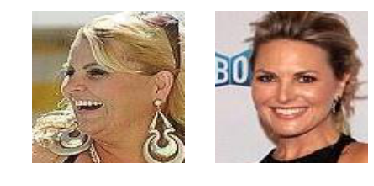

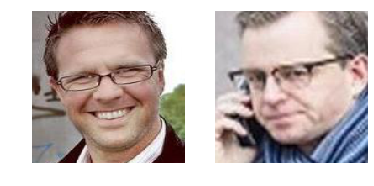

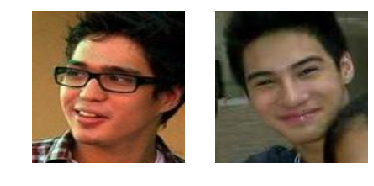

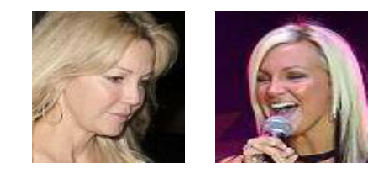

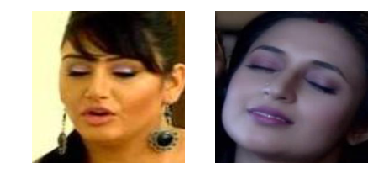

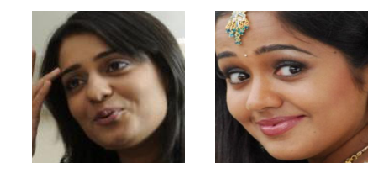

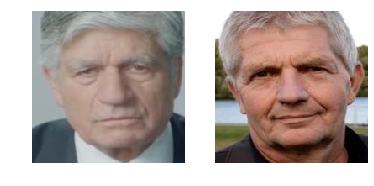

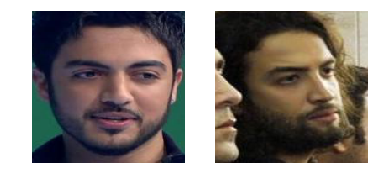

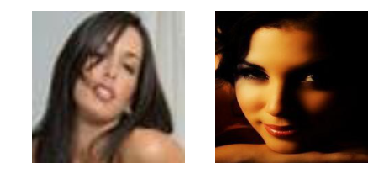

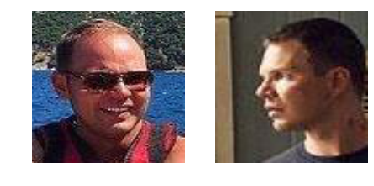

In [56]:
pair_wise_dist = dist(feature_mean_numpy)
rank = np.argsort(pair_wise_dist)
np.random.seed(0)
person_pair_name_list = []
for i in np.random.choice(len(id_list), 20):
    f, axarr = plt.subplots(1, 2)
    nei = rank[i, 1]
    img = get_image(id_list[i])
    img_nei = get_image(id_list[nei])
    axarr[0].imshow(img)
    axarr[0].axis('off')
    axarr[1].imshow(img_nei)
    #plt.title("person {} VS person {}".format(i, nei))
    axarr[1].axis('off')
    plt.show()
    person_pair_name_list.append((id_list[i], id_list[nei]))

In [45]:
print(person_pair_name_list)

[('n002660', 'n001243'), ('n001457', 'n003458'), ('n007986', 'n001354'), ('n002532', 'n002231'), ('n008529', 'n005526'), ('n006304', 'n008071'), ('n002121', 'n000035'), ('n006113', 'n005452'), ('n005059', 'n008990'), ('n002076', 'n007997'), ('n000155', 'n003031'), ('n007374', 'n006099'), ('n005516', 'n000205'), ('n003383', 'n004625'), ('n007161', 'n004544'), ('n006546', 'n000461'), ('n005850', 'n007499'), ('n009131', 'n000972'), ('n002369', 'n003961'), ('n005042', 'n004092')]


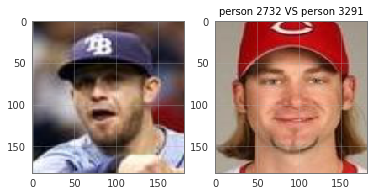

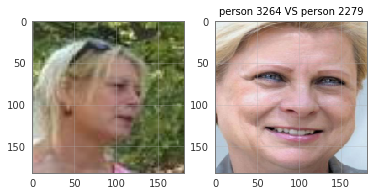

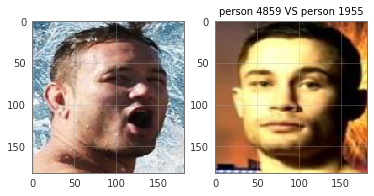

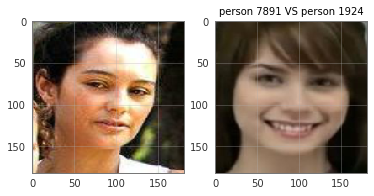

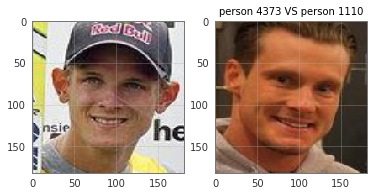

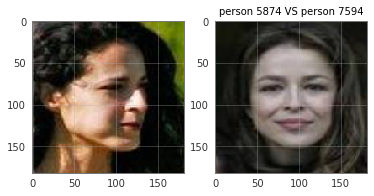

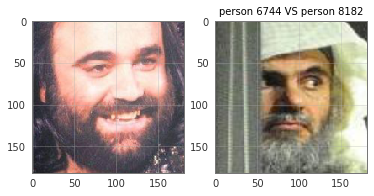

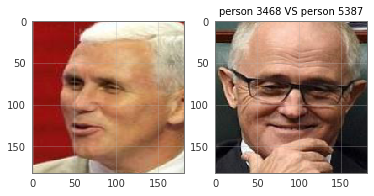

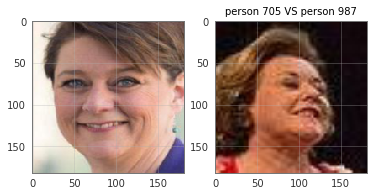

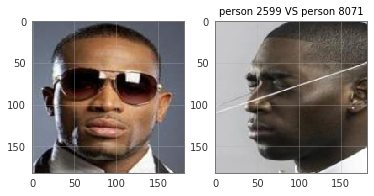

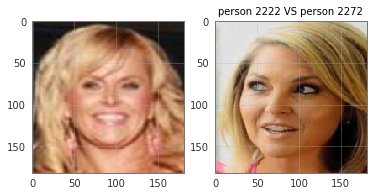

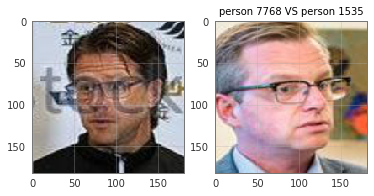

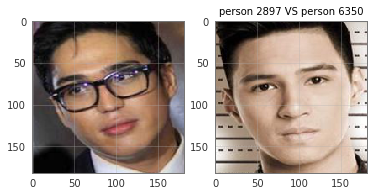

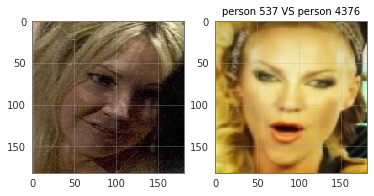

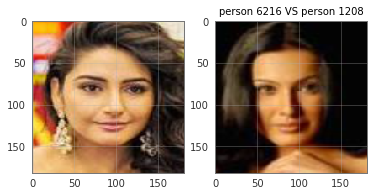

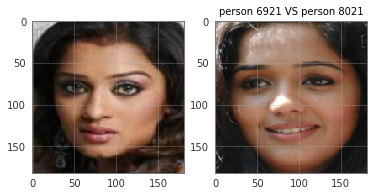

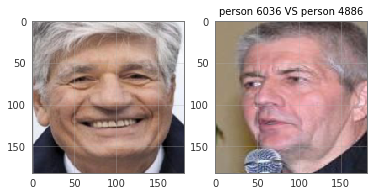

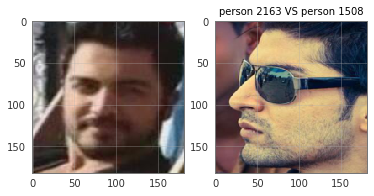

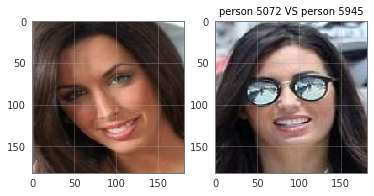

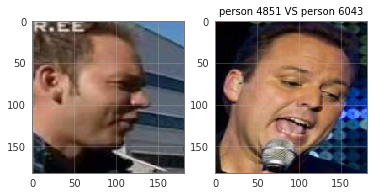

In [54]:
pair_wise_dist = dist(feature_mean_numpy, dist_type="cos")
rank = np.argsort(pair_wise_dist)
np.random.seed(0)
for i in np.random.choice(len(id_list), 20):
    f, axarr = plt.subplots(1, 2)
    nei = rank[i, 1]
    img = get_image(id_list[i])
    img_nei = get_image(id_list[nei])
    axarr[0].imshow(img)
    axarr[1].imshow(img_nei)
    plt.title("person {} VS person {}".format(i, nei))
    plt.show()